## get own data

In [1]:
import cv2
import os
import keras
import matplotlib.pyplot as plt
import matplotlib
import mtcnn
import tensorflow as tf
import numpy as np
import keras_vggface.utils
from PIL import Image
from keras_vggface.vggface import VGGFace
from keras.layers import Flatten, Dense

In [2]:
PROJECT_PATH = os.path.join(os.getcwd())

In [4]:
PROJECT_PATH

'/Users/devrrior/Repos/my_lab_ai/notebooks/my-own-face-detector-project'

In [3]:
DATASET_ID = input("Enter de ID:")

Enter de ID: fernando


In [4]:
DATASET_ID_DIRECTORY = os.path.join(PROJECT_PATH, 'new_dataset', DATASET_ID)

isExist = os.path.exists(DATASET_ID_DIRECTORY)

if isExist:
    print("Directory exists")
else:
    os.makedirs(DATASET_ID_DIRECTORY)
    print("Created directory")

Directory exists


In [7]:
camera = cv2.VideoCapture(0)
number_of_sample_faces = 200

HAARCASCADE_PATH = os.path.join(PROJECT_PATH, 'haarcascade_frontalface_default.xml')

face_detect = cv2.CascadeClassifier(HAARCASCADE_PATH)

for i in range(number_of_sample_faces):
    ret, img = camera.read()
    filename = os.path.join(DATASET_ID_DIRECTORY + "/" + str(i+1) + ".jpg")
    faces = face_detect.detectMultiScale(img, 1.3, 5)
    for x, y, w, h in faces:
        cv2.imwrite(filename, img[y : y + h, x : x + w])
        cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
    cv2.waitKey(75)

    cv2.imshow("Face", img)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break

camera.release()
cv2.destroyAllWindows()

## pre process

In [ ]:
face_detector = mtcnn.MTCNN()

In [ ]:
import os



def load_face(dir):
    faces = []
    # enumerate files
    for filename in os.listdir(dir):
        if filename.endswith("png") or filename.endswith("jpg") or filename.endswith("jpeg"):
            path = os.path.join(dir, filename)
            image = cv2.imread(path)
            img_roi = face_detector.detect_faces(image)
  
            if img_roi:
                x1, y1, width, height = img_roi[0]["box"]
                x2, y2 = x1 + width, y1 + height
                face_array = image[y1:y2, x1:x2]
                faces.extend(face_array)

                plt.imshow(face_array)
                plt.show()
            
    return faces        

original_folder_name = 'new_dataset/original'
original_images_dir = os.path.join(PROJECT_PATH, original_folder_name)

labels = []
faces_data = []

for dirName in os.listdir(original_images_dir):
    path = os.path.join(original_images_dir, dirName)
    if os.path.isdir(path):
        faces = load_face(path)
        faces_data.append(faces)
        labels.append(dirName)

In [ ]:
for data in faces_data:
    for face in data:
        plt.imshow(face)
        plt.show()

In [ ]:
from PIL import Image

processed_folder_name = 'new_dataset/processed'
processed_folder_dir = os.path.join(PROJECT_PATH, processed_folder_name)

for index, faces in enumerate(faces_data):
    l = labels[index]
    dir = os.path.join(processed_folder_dir, l)
    if not os.path.exists(dir):
        os.makedirs(dir)
    for index2, face in enumerate(faces): 
        cv2.imwrite(os.path.join(dir, f'{index2}.jpg' ), face)

## build

In [5]:
import os
import pandas as pd
import numpy as np

import tensorflow as keras
import matplotlib.pyplot as plt
from keras.layers import Dense, GlobalAveragePooling2D, Flatten
from keras.preprocessing import image
from keras.applications.mobilenet import preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import image_dataset_from_directory

In [25]:
batch_size = 32
img_height = 224
img_width = 224

processed_folder_name = 'new_dataset'
processed_folder_dir = os.path.join(PROJECT_PATH, processed_folder_name)

train_ds = image_dataset_from_directory(
  processed_folder_name,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = image_dataset_from_directory(
  processed_folder_name,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 185 files belonging to 1 classes.
Using 148 files for training.
Found 185 files belonging to 1 classes.
Using 37 files for validation.


In [26]:
class_names = train_ds.class_names
print(class_names)

['fernando']


2024-03-11 13:06:12.739981: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


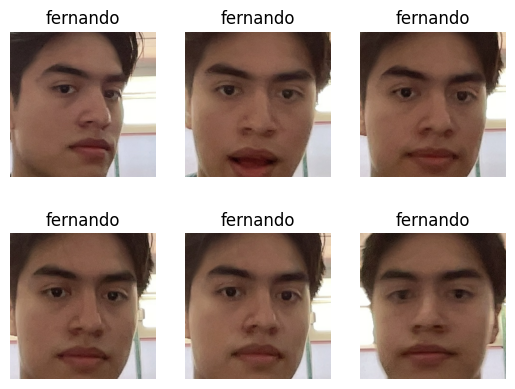

In [27]:
for images, labels in train_ds.take(1):
    for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
from keras import layers

# normalization
normalization_layer = layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))

In [29]:
# flipping and rotation
flip_layer = layers.RandomFlip("horizontal_and_vertical")
rotation_layer = layers.RandomRotation(0.2)
augment_layers = keras.keras.Sequential([flip_layer, rotation_layer]) # it will be added directly to the model later
augmented_ds = train_ds.map(lambda x, y: (augment_layers(x), y))

In [30]:
train_ds = train_ds.concatenate(augmented_ds)

In [31]:
from keras_vggface.vggface import VGGFace

base_model = VGGFace(model='vgg16',
    include_top=False, # load only feature extraction layers
    input_shape=(224, 224, 3))
base_model.summary()

Model: "vggface_vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)     

In [32]:
nb_class = len(class_names)

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# final layer with softmax activation
out = Dense(nb_class, activation='softmax')(x)

In [33]:
# new model
model = Model(inputs = base_model.input, outputs = out)
model.summary()

# not training the first 19 layers 
for layer in model.layers[:len(base_model.layers)]:
    layer.trainable = False

# train the rest
for layer in model.layers[len(base_model.layers):]:
    layer.trainable = True

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_1 (Conv2D)            (None, 224, 224, 64)      1792      
                                                                 
 conv1_2 (Conv2D)            (None, 224, 224, 64)      36928     
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 64)      0         
                                                                 
 conv2_1 (Conv2D)            (None, 112, 112, 128)     73856     
                                                                 
 conv2_2 (Conv2D)            (None, 112, 112, 128)     147584    
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 128)       0   

In [34]:
AUTOTUNE = keras.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
model.compile(optimizer='Adam',
    # if output is One hot encoded (ie: [0, 0, 1, 0]) 
    # use CategoricalCrossentropy
    loss= keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy'])

model.fit(
    train_ds,
    batch_size = 1,
    validation_data=val_ds,
    verbose = 1,
    epochs = 10
)

Epoch 1/10
10/10 [==============================] - 38s 4s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
10/10 [==============================] - 43s 4s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 3/10
10/10 [==============================] - 49s 5s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 4/10
10/10 [==============================] - 53s 5s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 5/10
10/10 [==============================] - 49s 5s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 6/10
10/10 [==============================] - 50s 5s/step - loss: 0.0000e+00 - accuracy: 0.0000e+00 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 7/10
10/10 [==============================] - 49s 5s/step 